# A quick tutorial for H5coro

#### Author:  Yiyu Ni
#### Email: niyiyu@uw.edu
#### Last update: Aug. 11, 2021

### First, we import the required ingredients...
### ... and define the file we want to access. Here we access a sample ASDF file from seisbasin bucket.
Currently, H5coro supports two types of acccess:

1. Local access
```
resource = "filename"
format   = "file"
path     = "path_to_file"
region   = ""
endpoint = ""
```

2. S3 access 
```
resource = "filename"
format   = "s3"
path     = "path_to_file"
region   = "us-west-2"
endpoint = "https://s3.us-west-2.amazonaws.com"
```
⚠️**Make sure you have the access to the s3 bucket.**

In [2]:
import srpybin
import numpy as np
import obspy
import datetime
import io
import time

resource = "UW_ALL_2021-01-01__2021-01-01.h5"
# format = "s3"
# path = "seisbasin/ASDF/"
# region = "us-west-2"
# endpoint = "https://s3.us-west-2.amazonaws.com"

# resource = "UW_ALL_2021-01-01__2021-01-01.h5"
# resource = "asdf.h5"
format = "file"
path = "./data/"
region = ""
endpoint = ""

h5file = srpybin.h5coro(resource, format, path, region, endpoint)

H5coro has two method:
```
H5file.read("/groups/dataset", row_begin, column_begin, num_column) 
```    
that performs a single dataset read

```
H5file.readp(datasets)
```
that performs parallel dataset read

### Serial StationXML read and parsing (into ObsPy StationXML)

In [3]:
# We do a serial read to the StationXML object of UW.OSD object...
stationxml = h5file.read("/Waveforms/UW.OSD/StationXML", 0, 0, -1)

# ... and convert them into ObsPy StationXML object.
stationxml = np.array(stationxml, dtype = 'int8')
stationxml = stationxml[()].tobytes().strip()
obspy.read_inventory(io.BytesIO(stationxml), format="stationxml")

Inventory created at 2021-08-11T07:38:50.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			UW
		Stations (1):
			UW.OSD (Olympics - Snow Dome)
		Channels (4):
			UW.OSD..EHZ, UW.OSD..ENZ, UW.OSD..ENN, UW.OSD..ENE

### Serial waveform read and parsing (into ObsPy Trace)

In [20]:
traceid = "/Waveforms/UW.DAVN/UW.DAVN..BHZ__2021-01-05T00:00:00__2021-01-06T14:09:52__raw_recording"
waveform = h5file.read(traceid, 0, 0, -1)
_tr = obspy.Trace(data = np.array(waveform))
starttime = datetime.datetime.strptime(traceid.split("__")[1], "%Y-%m-%dT%H:%M:%S")
endtime = datetime.datetime.strptime(traceid.split("__")[2], "%Y-%m-%dT%H:%M:%S")
delta = (endtime - starttime).total_seconds()
sampling_rate = (len(_tr.data)-1)/delta
setattr(_tr.stats, "starttime", starttime)
setattr(_tr.stats, "sampling_rate", sampling_rate)
_tr

... | 2021-01-05T00:00:00.000000Z - 2021-01-06T14:09:52.000000Z | 40.0 Hz, 5495701 samples

Note that the sampling rate and start/end time matches the key `UW.DAVN..BHZ__2021-01-05T00:00:00__2021-01-06T14:09:52`

### Parallel waveform read and parsing (into ObsPy Stream)
⚠️Be cautious when performing parallel reading. Remember to check whether the key exist or not, otherwise the library will die.

In [7]:
# We do a parallel read to the  object of UW.OSD object...
datasets = [["/Waveforms/UW.OSD/UW.OSD..EHZ__2021-01-01T00:00:00__2021-01-01T00:10:00__raw_recording", 0, 0, -1],
            ["/Waveforms/UW.OSD/UW.OSD..ENE__2021-01-01T00:00:00__2021-01-01T00:10:00__raw_recording", 0, 0, -1],
            ["/Waveforms/UW.OSD/UW.OSD..ENN__2021-01-01T00:00:00__2021-01-01T00:10:00__raw_recording", 0, 0, -1],
            ["/Waveforms/UW.OSD/UW.OSD..ENZ__2021-01-01T00:00:00__2021-01-01T00:10:00__raw_recording", 0, 0, -1]]

# ... and convert them into ObsPy Stream object.
waveform = h5file.readp(datasets)
stream = obspy.Stream()
for traceid in waveform:
    __tr = obspy.Trace(data = np.array(waveform[traceid]))

    starttime = datetime.datetime.strptime(traceid.split("__")[1], "%Y-%m-%dT%H:%M:%S")
    endtime = datetime.datetime.strptime(traceid.split("__")[2], "%Y-%m-%dT%H:%M:%S")
    delta = (endtime - starttime).total_seconds()
    sampling_rate = (len(__tr.data)-1)/delta
    setattr(__tr.stats, "starttime", starttime)
    setattr(__tr.stats, "sampling_rate", sampling_rate)
    stream.append(__tr)
print(stream)

4 Trace(s) in Stream:
... | 2021-01-01T00:00:00.000000Z - 2021-01-01T00:10:00.000000Z | 100.0 Hz, 60001 samples
... | 2021-01-01T00:00:00.000000Z - 2021-01-01T00:10:00.000000Z | 100.0 Hz, 60001 samples
... | 2021-01-01T00:00:00.000000Z - 2021-01-01T00:10:00.000000Z | 100.0 Hz, 60001 samples
... | 2021-01-01T00:00:00.000000Z - 2021-01-01T00:10:00.000000Z | 100.0 Hz, 60001 samples


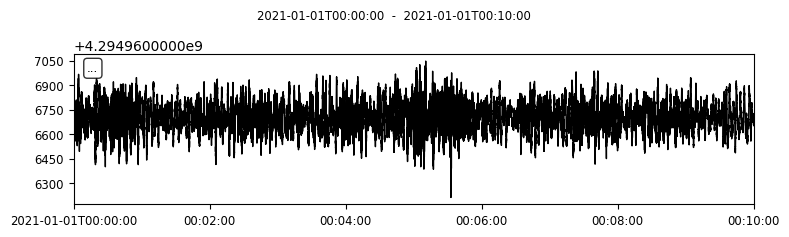

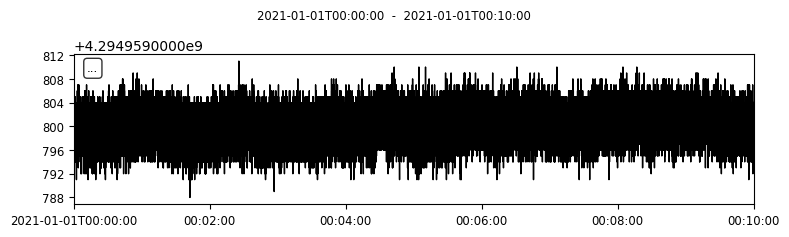

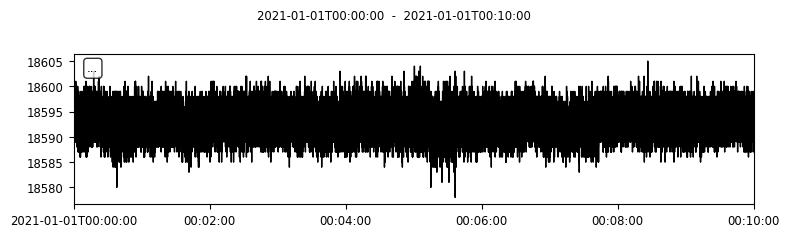

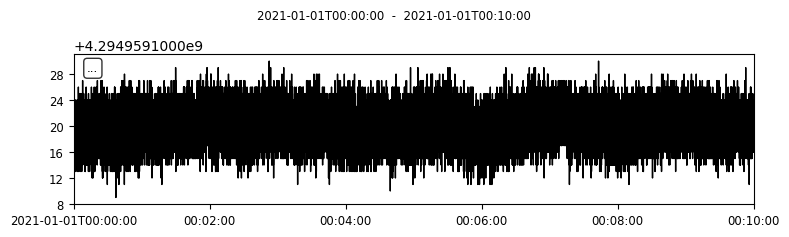

In [8]:
for trace in stream:
    trace.plot()

### Serial QuakeML read and parsing (into ObsPy quake catelog object)

In [9]:
# We do a serial read to the EventXML object ...
eventxml = h5file.read("/QuakeML", 0, 0, -1)

# ... and convert them into ObsPy StationXML object.
eventxml = np.array(eventxml, dtype = 'int8')
eventxml = eventxml[()].tobytes().strip()
obspy.read_events(io.BytesIO(eventxml), format="quakeml")

555 Event(s) in Catalog:
2021-01-31T23:20:48.932000Z | -31.757,  -68.964 | 4.7 Mwr
2021-01-31T22:54:20.147000Z | +19.771, +121.348 | 4.7 mb
...
2021-01-01T01:20:09.649000Z | -31.319, -177.934 | 5.0 mb
2021-01-01T00:40:35.958000Z | -52.228,   -4.801 | 5.3 Mww
To see all events call 'print(CatalogObject.__str__(print_all=True))'

### ⚠️Problems we have here

1. As in ASDF, if there're gaps in traces, the traces will not be merged into one single dataset. In fact, they will be in separate dataset.

2. Because of 1., for complex data from real world, we hardly could speculate what the RIGHT name of datasets. On the other hand, it's not possible to run `h5dump -n asdf.h5` on the cloud.

3. For the file `asdf.h5` as illustrated above, we actually have:

```
HDF5 "asdf.h5" {
FILE_CONTENTS {
 group      /
 group      /AuxiliaryData
 dataset    /AuxiliaryData/ASDFDict
 group      /Provenance
 dataset    /QuakeML
 group      /Waveforms
 group      /Waveforms/UW.DAVN
 dataset    /Waveforms/UW.DAVN/StationXML
 dataset    /Waveforms/UW.DAVN/UW.DAVN..BHZ__2021-01-01T00:00:00__2021-01-02T23:59:59__raw_recording
 dataset    /Waveforms/UW.DAVN/UW.DAVN..BHZ__2021-01-03T00:00:00__2021-01-04T23:59:59__raw_recording
 dataset    /Waveforms/UW.DAVN/UW.DAVN..BHZ__2021-01-05T00:00:00__2021-01-06T14:09:52__raw_recording
 dataset    /Waveforms/UW.DAVN/UW.DAVN..BHZ__2021-01-06T14:09:53__2021-01-08T23:59:59__raw_recording
 dataset    /Waveforms/UW.DAVN/UW.DAVN..BHZ__2021-01-09T00:00:00__2021-01-10T23:59:59__raw_recording
 dataset    /Waveforms/UW.DAVN/UW.DAVN..BHZ__2021-01-11T00:00:00__2021-01-12T23:59:59__raw_recording
 dataset    /Waveforms/UW.DAVN/UW.DAVN..BHZ__2021-01-13T00:00:00__2021-01-15T00:00:00__raw_recording
 group      /Waveforms/UW.OSD
 dataset    /Waveforms/UW.OSD/StationXML
 dataset    /Waveforms/UW.OSD/UW.OSD..EHZ__2021-01-01T00:00:00__2021-01-01T00:10:00__raw_recording
 dataset    /Waveforms/UW.OSD/UW.OSD..ENE__2021-01-01T00:00:00__2021-01-01T00:10:00__raw_recording
 dataset    /Waveforms/UW.OSD/UW.OSD..ENN__2021-01-01T00:00:00__2021-01-01T00:10:00__raw_recording
 dataset    /Waveforms/UW.OSD/UW.OSD..ENZ__2021-01-01T00:00:00__2021-01-01T00:10:00__raw_recording
 }
}
```

### Here illustrates a method as workaround:
- We save the structure of ASDF file (as Python Dict) before uploading to the cloud. 
- When we need to read the data, we download the `/AuxiliaryData/ASDFDict` dataset and parse them into Dictionary.
- Thus, we know what data the file contains.

**This is just a proposal... Performance haven't been test yet. Also feel free to propose other solution!**

In [13]:
asdfstring = h5file.read("/AuxiliaryData/ASDFDict", 0, 0, -1)
ASDFDict = eval(np.array(asdfstring, dtype = 'int8')[()].tobytes().strip().decode("utf-8"))

This is what we get here. The string is 929-char long, int8 type. **Although it takes up only 0.0015% of the entire file,** obviously here're some compressing algorithms available like Huffman Encoding (not worth it).

In [14]:
ASDFDict

{'/': ['AuxiliaryData', 'Provenance', 'QuakeML', 'Waveforms'],
 'Waveforms': {'UW.DAVN': ['StationXML',
   'UW.DAVN..BHZ__2021-01-01T00:00:00__2021-01-02T23:59:59__raw_recording',
   'UW.DAVN..BHZ__2021-01-03T00:00:00__2021-01-04T23:59:59__raw_recording',
   'UW.DAVN..BHZ__2021-01-05T00:00:00__2021-01-06T14:09:52__raw_recording',
   'UW.DAVN..BHZ__2021-01-06T14:09:53__2021-01-08T23:59:59__raw_recording',
   'UW.DAVN..BHZ__2021-01-09T00:00:00__2021-01-10T23:59:59__raw_recording',
   'UW.DAVN..BHZ__2021-01-11T00:00:00__2021-01-12T23:59:59__raw_recording',
   'UW.DAVN..BHZ__2021-01-13T00:00:00__2021-01-15T00:00:00__raw_recording'],
  'UW.OSD': ['StationXML',
   'UW.OSD..EHZ__2021-01-01T00:00:00__2021-01-01T00:10:00__raw_recording',
   'UW.OSD..ENE__2021-01-01T00:00:00__2021-01-01T00:10:00__raw_recording',
   'UW.OSD..ENN__2021-01-01T00:00:00__2021-01-01T00:10:00__raw_recording',
   'UW.OSD..ENZ__2021-01-01T00:00:00__2021-01-01T00:10:00__raw_recording']}}